(other_nuts_samplers)=
# Other NUTS Samplers

In this notebook we show how to fit a CLV model with other NUTS samplers. These alternative samplers can be significantly faster and also sample on the GPU.

```{note}
You need to install these packages in your Python environment.
```

```{tip}
You can pass the exact same `nuts_sampler` argument to the MMM models. 
```

For the purpose of illustration, we will use the same data and model as in the other CLV notebooks.


In [2]:
import arviz as az
import matplotlib.pyplot as plt
from lifetimes.datasets import load_cdnow_summary

from pymc_marketing import clv

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df = (
    load_cdnow_summary(index_col=[0])
    .reset_index()
    .rename(columns={"ID": "customer_id"})
)

We can pass the keyword argument `nuts_sampler` to the `fit` method of the `CLV` model to specify the NUTS sampler to use. In addition, we can pass additional keyword arguments which will be passed to the [`pymc.sample`](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sampling.mcmc.sample.html#pymc.sampling.mcmc.sample) method via the model builder layer.  For example, we can use the `numpyro` sampler as:

In [9]:
sampler_kwargs = {
    "draws": 2_000,
    "target_accept": 0.9,
    "chains": 5,
    "random_seed": 42,
}

model = clv.BetaGeoModel(data=df)

In [14]:
model.__repr__
import sys

def total_size(obj, seen=None):
    """Recursively finds the size of objects."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0  # Avoid counting the same object twice
    seen.add(obj_id)
    
    if isinstance(obj, dict):
        size += sum([total_size(v, seen) for v in obj.values()])
        size += sum([total_size(k, seen) for k in obj.keys()])
    elif isinstance(obj, (list, tuple, set, frozenset)):
        size += sum([total_size(i, seen) for i in obj])
    
    return size

# Example usage
print(f"Total size of my_variable: {total_size(model)} bytes")


Total size of my_variable: 48 bytes


Finally, we can use the `nutpie` which is a Rust implementation of NUTS.

In [6]:
idata_nutpie = model.fit(nuts_sampler="nutpie", **sampler_kwargs)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.42,15
,3000,0,0.39,3
,3000,0,0.46,15
,3000,0,0.41,15
,3000,0,0.44,15


The results from the samplers are almost identical:

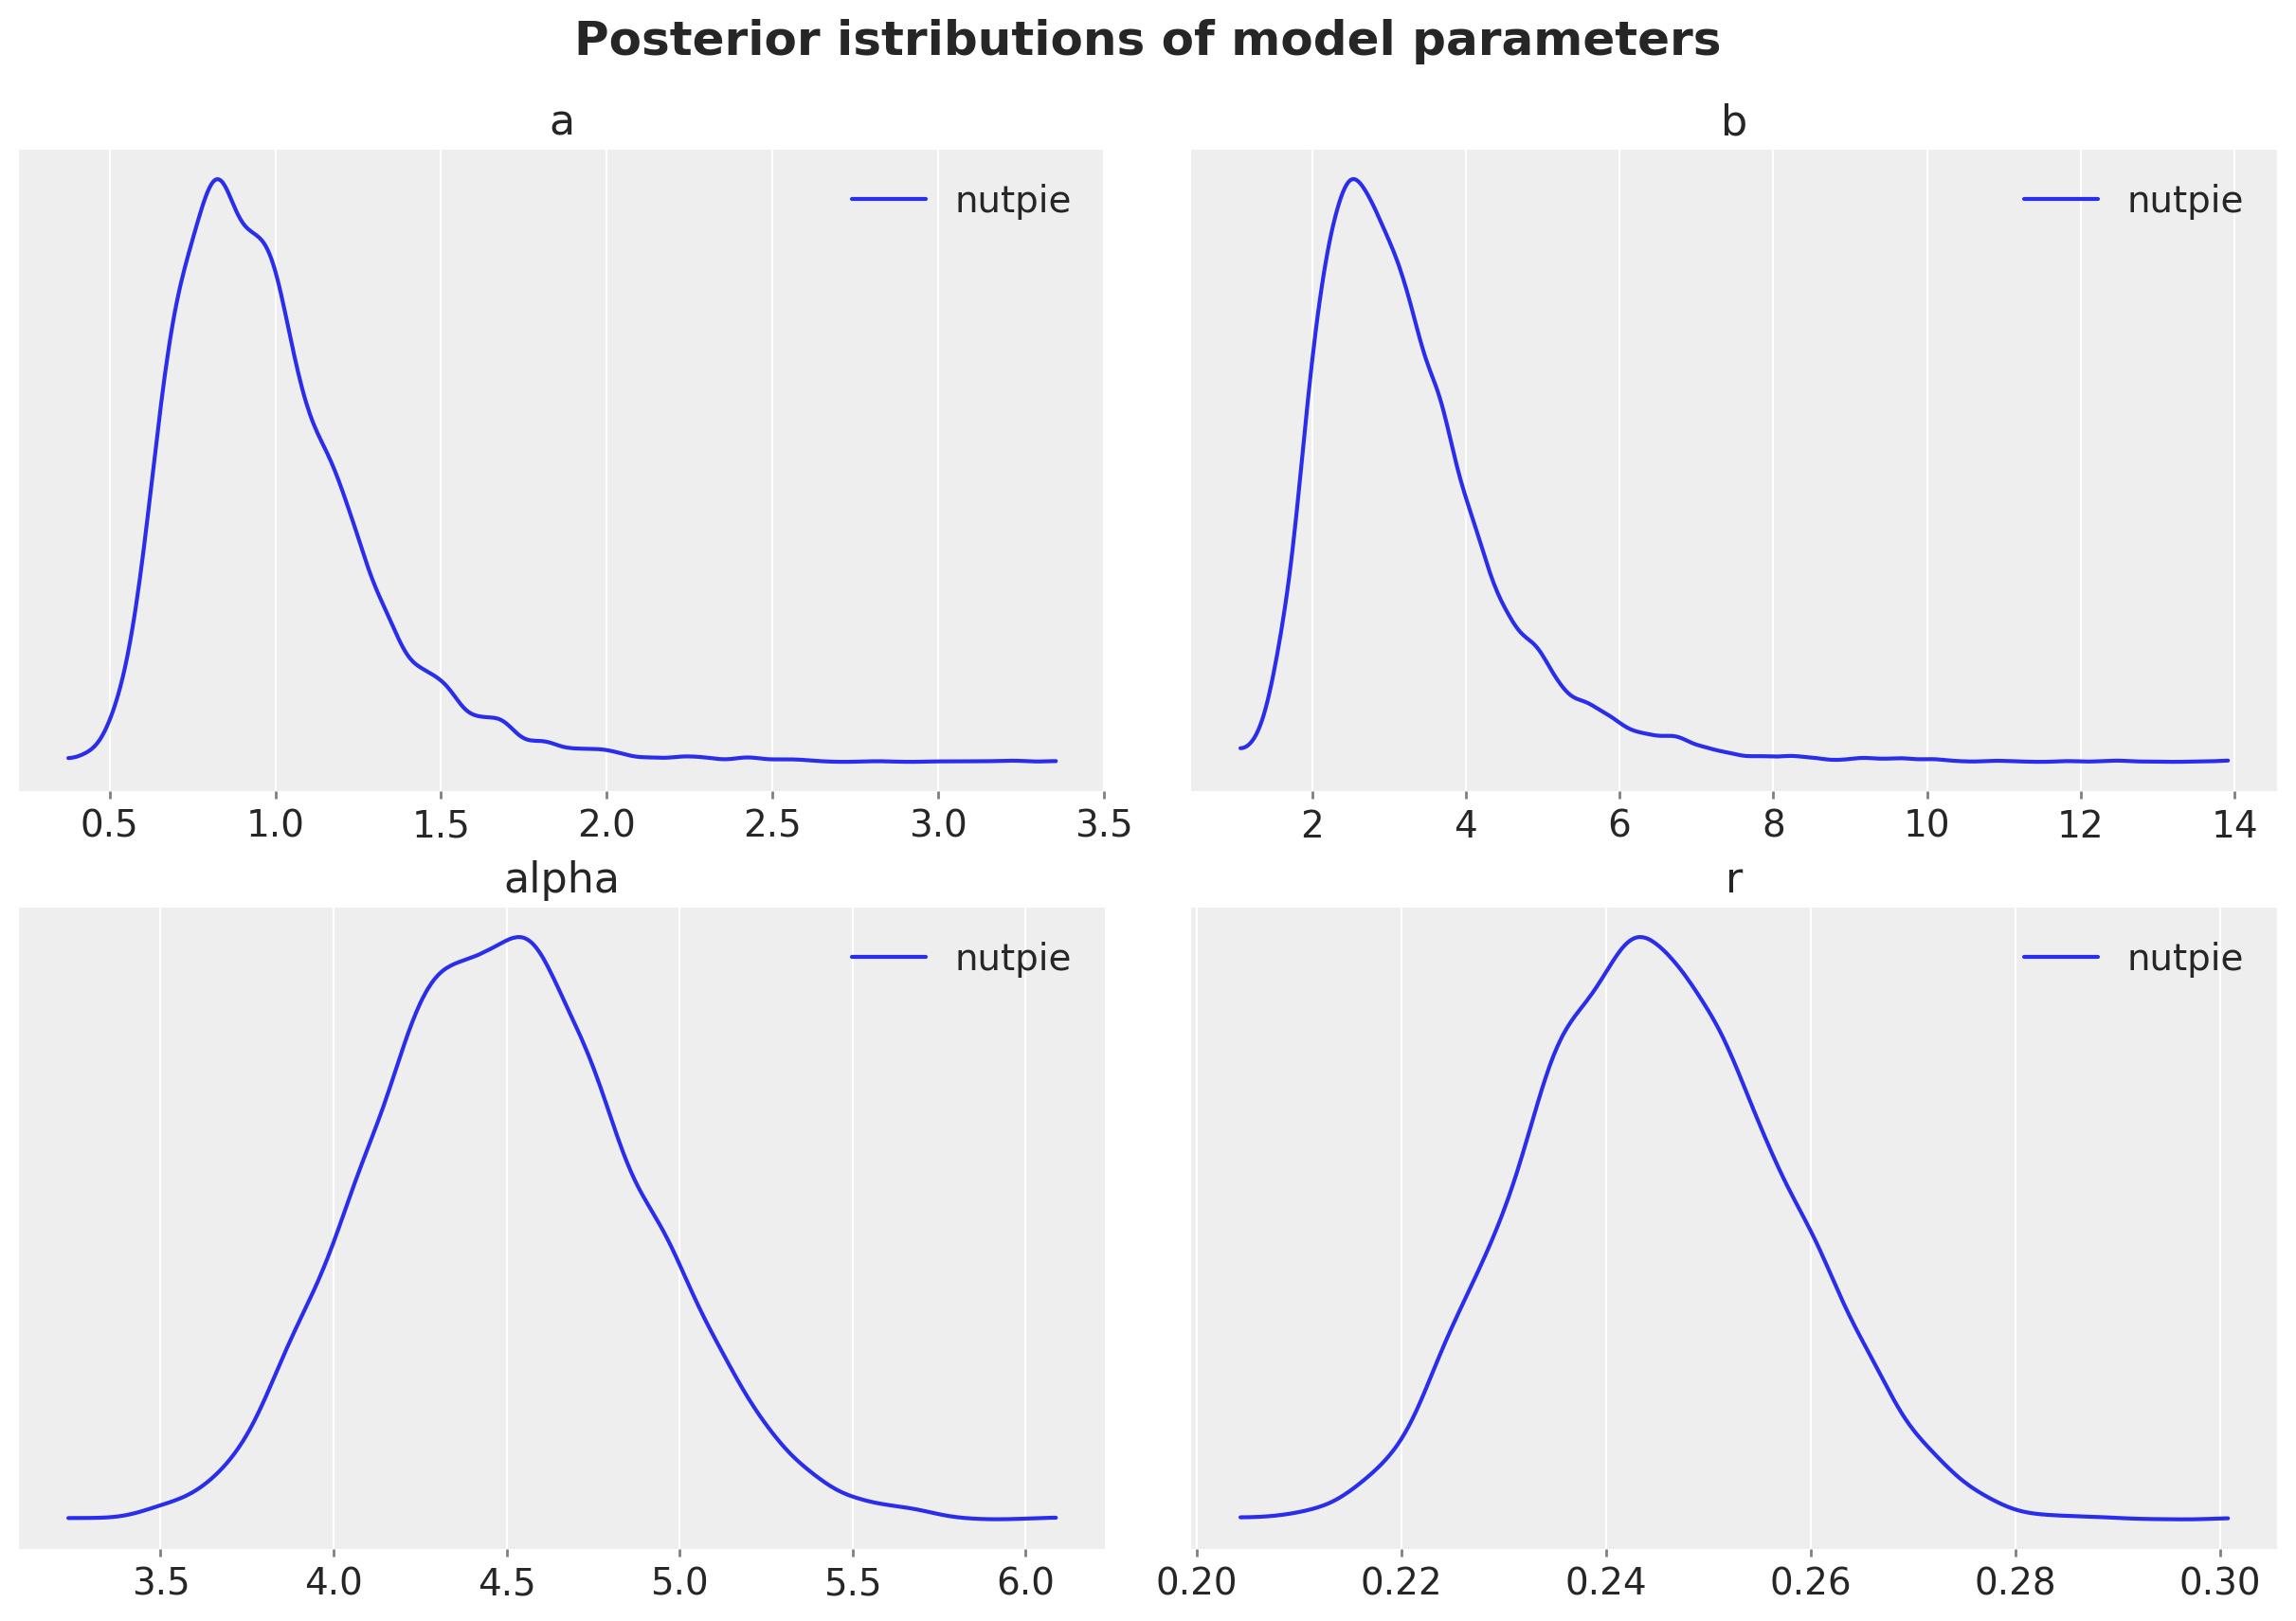

In [8]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8), sharex=False, sharey=False, layout="constrained"
)

axes = axes.ravel()

for i, var_name in enumerate(["a", "b", "alpha", "r"]):
    for j, (idata, label) in enumerate(
        zip(
            [
                idata_nutpie],
            [ "nutpie"],
            strict=False,
        )
    ):
        az.plot_posterior(
            data=idata,
            var_names=[var_name],
            color=f"C{j}",
            point_estimate=None,
            hdi_prob="hide",
            label=label,
            ax=axes[i],
        )

fig.suptitle(
    "Posterior istributions of model parameters",
    fontsize=18,
    fontweight="bold",
    y=1.05,
);

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p blackjax,numpyro,nutpie,pymc

Last updated: Sat Mar 09 2024

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.20.0

blackjax: 0.0.0
numpyro : 0.14.0
nutpie  : 0.9.2
pymc    : 5.10.4

arviz         : 0.15.1
matplotlib    : 3.7.1
pymc_marketing: 0.4.0

Watermark: 2.4.3

